<a href="https://colab.research.google.com/github/aldnoahh/rice-disease-classifier/blob/master/RDR_VGG19_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Plant Disease Recognition using VGG19 on Custom Dataset.


Importing necessary libraries

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.applications.vgg19 import VGG19 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Downloading and unzipping the modified dataset available on Gdrive. If you don`t have gdown module, install it using pip.

In [4]:
!cp "/content/drive/My Drive/rdr/res600.zip" ./

In [5]:
%%capture
!unzip res600.zip

Check if the folder has been unzipped.

In [6]:
!ls

drive  res600  res600.zip  sample_data


Setting up path for datagenerators from keras

In [7]:
train_path = '/content/res600/train'
valid_path = '/content/res600/test'
# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')
# useful for getting number of classes
folders = glob(train_path + '/*')
len(folders)
print(image_files)
print(valid_image_files)

['/content/res600/train/05/05__IMG_20190419_135937.jpg', '/content/res600/train/05/05__IMG_20190419_131924.jpg', '/content/res600/train/05/05__IMG_20190419_140257.jpg', '/content/res600/train/05/05__IMG_3104.jpg', '/content/res600/train/05/05__IMG_20190419_162121.jpg', '/content/res600/train/05/05__IMG_2977.jpg', '/content/res600/train/05/05__IMG_4924.jpg', '/content/res600/train/05/05__IMG_20190419_124357.jpg', '/content/res600/train/05/05__IMG_20190419_115250.jpg', '/content/res600/train/05/05__IMG_5506.jpg', '/content/res600/train/05/05__IMG_20190419_135017.jpg', '/content/res600/train/05/05__IMG_20190419_114653.jpg', '/content/res600/train/05/05__IMG_20190419_170726.jpg', '/content/res600/train/05/05__IMG_20190419_175212.jpg', '/content/res600/train/05/05__IMG_3020.jpg', '/content/res600/train/05/05__IMG_20190419_112523.jpg', '/content/res600/train/05/05__IMG_20190419_135054.jpg', '/content/res600/train/05/05__IMG_20190419_173221.jpg', '/content/res600/train/05/05__IMG_20190419_115

Specify input image size.

In [8]:
IMAGE_SIZE = [300, 300]

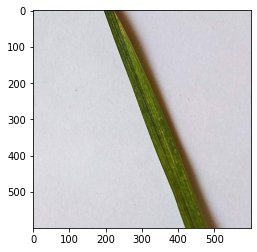

In [9]:
#sneek peek at a random image
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

Configuring the pretrainned model as per our needs.

In [10]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)
# freeze pretrained model weights
ptm.trainable = False

80142336/80134624 [==============================] - 1s 0us/step


In [11]:
K = len(folders) # number of classes

#model definition
x = Flatten()(ptm.output)
x= BatchNormalization()(x)
x= Dense(256,activation='relu')(x)
x= BatchNormalization()(x)
x= Dense(128,activation='relu')(x)
x = Dense(K, activation='softmax')(x)

In [12]:
# create a model object
model = Model(inputs=ptm.input, outputs=x)

In [13]:
# view the structure of the model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)      

In [14]:
#view the number of layers in the model
len(model.layers)

28

In [15]:
# create an instance of ImageDataGenerator
#Keras generators returns one-hot encoded labels and provides data augmentation.
gen_train = ImageDataGenerator(
  rotation_range=90,
  width_shift_range=0.09,
  height_shift_range=0.09,
  shear_range=0.15,
  zoom_range=0.1,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

gen_test = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

In [16]:
#batch size is the number of examples that are run through the model at once.
batch_size = 100

# create generators
train_generator = gen_train.flow_from_directory(
  train_path,
  shuffle=True,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)
valid_generator = gen_test.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)

Found 5230 images belonging to 8 classes.
Found 925 images belonging to 8 classes.


Since Keras no longer provides some metrics within itself, so we define those metrics ourselves. Here, we are defining F1_score, Precision and Recall.

In [17]:
from keras import backend as Ke

def recall_m(y_true, y_pred):
    true_positives = Ke.sum(Ke.round(Ke.clip(y_true * y_pred, 0, 1)))
    possible_positives = Ke.sum(Ke.round(Ke.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + Ke.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = Ke.sum(Ke.round(Ke.clip(y_true * y_pred, 0, 1)))
    predicted_positives = Ke.sum(Ke.round(Ke.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + Ke.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+Ke.epsilon()))
#Ke.clear_session()


This block is for creating a lr scheduler, since the lr scheduler was not as effective as using adam directly, it is left for experimentation.

In [ ]:
#from keras.optimizers import Adam
#import math
#def step_decay(epoch):
#	initial_lrate = 0.0005
#	drop = 0.5
#	epochs_drop = 10.0
#	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
#	return lrate
#opt = Adam(lr=0.0)


In [18]:
from keras.callbacks import *
filepath = "/content/drive/My Drive/rdr/mods/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Compiling our model with loss, optimizer and metrics (including our custom defined ones).

In [19]:
opt=tf.keras.optimizers.Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['acc',f1_m,precision_m, recall_m]
)

In [ ]:
# # learning schedule callback
# from keras.callbacks import LearningRateScheduler
# lrate = LearningRateScheduler(step_decay)
# callbacks_list = [lrate]

In [20]:
model.load_weights('/content/drive/My Drive/rdr/mods/epochs:042-val_acc:0.825.hdf5')

The fit function is called for starting our training. 


In [21]:
# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=50,
  steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
  validation_steps=int(np.ceil(len(valid_image_files) / batch_size)),
  callbacks= callbacks_list,
)

Epoch 1/50
53/53 [==============================] - ETA: 0s - loss: 0.4244 - acc: 0.8317 - f1_m: 0.8296 - precision_m: 0.8638 - recall_m: 0.7984
Epoch 00001: val_acc improved from -inf to 0.80973, saving model to /content/drive/My Drive/rdr/mods/epochs:001-val_acc:0.810.hdf5
53/53 [==============================] - 169s 3s/step - loss: 0.4244 - acc: 0.8317 - f1_m: 0.8296 - precision_m: 0.8638 - recall_m: 0.7984 - val_loss: 0.4779 - val_acc: 0.8097 - val_f1_m: 0.8160 - val_precision_m: 0.8527 - val_recall_m: 0.7830
Epoch 2/50
53/53 [==============================] - ETA: 0s - loss: 0.4391 - acc: 0.8289 - f1_m: 0.8257 - precision_m: 0.8626 - recall_m: 0.7924
Epoch 00002: val_acc improved from 0.80973 to 0.81622, saving model to /content/drive/My Drive/rdr/mods/epochs:002-val_acc:0.816.hdf5
53/53 [==============================] - 165s 3s/step - loss: 0.4391 - acc: 0.8289 - f1_m: 0.8257 - precision_m: 0.8626 - recall_m: 0.7924 - val_loss: 0.5187 - val_acc: 0.8162 - val_f1_m: 0.8152 - val_

Saving our Model in HD5 format.

In [22]:
model.save("mod.h5")
print("Saved model to disk")

Saved model to disk


Graphs for our metrics

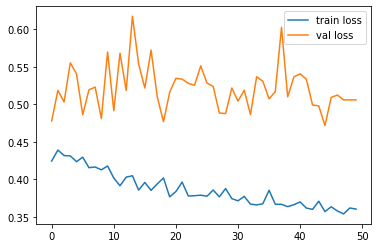

In [23]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

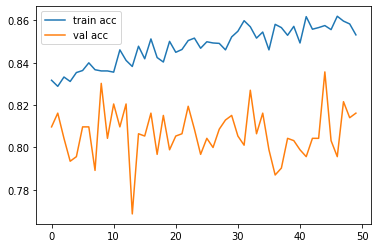

In [24]:
# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()

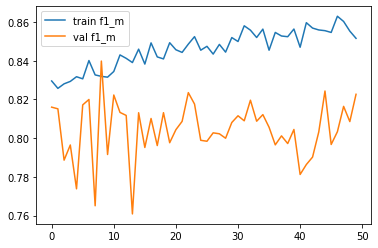

In [25]:
# f1_score
plt.plot(r.history['f1_m'], label='train f1_m')
plt.plot(r.history['val_f1_m'], label='val f1_m')
plt.legend()
plt.show()

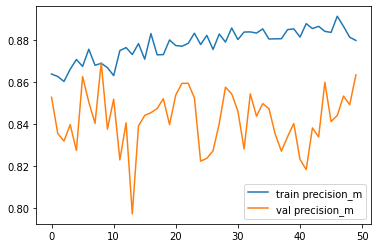

In [26]:
# precision
plt.plot(r.history['precision_m'], label='train precision_m')
plt.plot(r.history['val_precision_m'], label='val precision_m')
plt.legend()
plt.show()

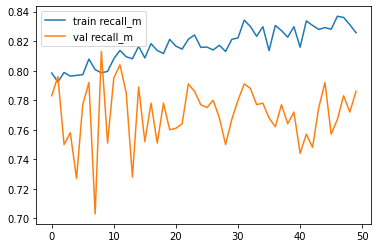

In [27]:
# recall
plt.plot(r.history['recall_m'], label='train recall_m')
plt.plot(r.history['val_recall_m'], label='val recall_m')
plt.legend()
plt.show()

Next we evaluate the model on our test set again.

In [28]:
# evaluate the model
valid_generator = gen_test.flow_from_directory(valid_path,target_size=IMAGE_SIZE,batch_size=batch_size,)
loss, accuracy, f1_score, precision, recall = model.evaluate(valid_generator, steps=int(np.ceil(len(valid_image_files)/ batch_size)))

Found 925 images belonging to 8 classes.
10/10 [==============================] - 13s 1s/step - loss: 0.5061 - acc: 0.8162 - f1_m: 0.8189 - precision_m: 0.8665 - recall_m: 0.7770


Printing our metrics

In [29]:
print('loss     : ',loss)
print('accuracy : ',accuracy)
print('f1_score :',f1_score)
print('precision:',precision)
print('recall   :',recall)

loss     :  0.5060961246490479
accuracy :  0.816216230392456
f1_score : 0.8189276456832886
precision: 0.8664876818656921
recall   : 0.7769999504089355


In [ ]:

import numpy as np
from google.colab import files
from keras.preprocessing import image
key= ['Blast', 'Blight', 'Brownspot', 'Healthy', 'Hispa', 'LeafBlast', 'Sheath blight', 'Tungro']

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  ly= classes[0].tolist()
  print(key[ly.index(max(ly))])